In [1]:
import os
import sys
import cv2
import numpy as np
import math
from keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D
from keras.models import Model
import matplotlib.pyplot as plt
import random
%matplotlib inline

Using TensorFlow backend.


In [2]:
path = os.getcwd()+'\\photos'
mask_path = os.getcwd()+'\\Maskedimages'
dim = (300, 300)
img_dict = {}
mask_dict = {}
for filename in os.listdir(path):
    img_dict[filename] = cv2.imread(os.path.join(path, filename))
    mask_dict[filename] = cv2.imread(os.path.join(mask_path, filename))

In [3]:
x_train = []
x_test = []
y_train = []
y_test = []

train_names = random.sample( img_dict.keys(), 70 )
test_names = [name for name in list(img_dict.keys()) if name not in train_names]

x_train = np.array([ img_dict[name] for name in train_names ])
print(x_train.shape)
x_test = np.array([ img_dict[name] for name in test_names ])
print(x_test.shape)

y_train = np.array([ mask_dict[name] for name in train_names ])
print(y_train.shape)
y_test = np.array([ mask_dict[name] for name in test_names ])
print(y_test.shape)

(70,)
(18,)
(70,)
(18,)


In [4]:
x_train_images = []
y_train_images = []
y_test_images = []
x_test_images = []
for i in range(len(x_train)):
    x_train_images.append(cv2.resize(x_train[i], (300,300)))
    y_train_images.append(cv2.resize(y_train[i], (300,300)))
for j in range(len(x_test)):
    x_test_images.append(cv2.resize(x_test[j], (300,300)))
    y_test_images.append(cv2.resize(y_test[j], (300,300)))
x_train_images = np.asarray(x_train_images)
y_train_images = np.asarray(y_train_images)
x_test_images = np.asarray(x_test_images)
y_test_images = np.asarray(y_test_images)

In [5]:
x_train = x_train_images.astype('float32') / 255
y_train = y_train_images.astype('float32') / 255

In [6]:
inputs = Input(shape=(300, 300, 3))  # adapt this if using `channels_first` image data format
# mask_img = Input(shape=(300, 300, 3))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPool2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 8)       1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 38, 38, 8)         0         
__________

In [8]:
autoencoder.fit(x_train.reshape(-1, 300, 300, 3), y_train.reshape(-1, 300, 300, 3),
                epochs=20,
                batch_size=1,
                shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
70/70 [==============================] - 14s 204ms/step - loss: 0.2260
Epoch 2/20
70/70 [==============================] - 3s 43ms/step - loss: 0.1519
Epoch 3/20
70/70 [==============================] - 3s 43ms/step - loss: 0.1467
Epoch 4/20
70/70 [==============================] - 3s 42ms/step - loss: 0.1436
Epoch 5/20
70/70 [==============================] - 3s 43ms/step - loss: 0.1410
Epoch 6/20
70/70 [==============================] - 3s 43ms/step - loss: 0.1405
Epoch 7/20
70/70 [==============================] - 3s 41ms/step - loss: 0.1408
Epoch 8/20
70/70 [==============================] - 3s 43ms/step - loss: 0.1387
Epoch 9/20
70/70 [==============================] - 3s 43ms/step - loss: 0.1386
Epoch 10/20
70/70 [==============================] - 3s 42ms/step - loss: 0.1378
Epoch 11/20
70/70 [==============================] - 3s 43ms/step - loss: 0.1312: 0s - los
Epoch 12/20
70/70 [==============================] - 3s 42

In [9]:
x_test_img = x_test_images.astype('float32') / 255
y_test_img = y_test_images.astype('float32') / 255

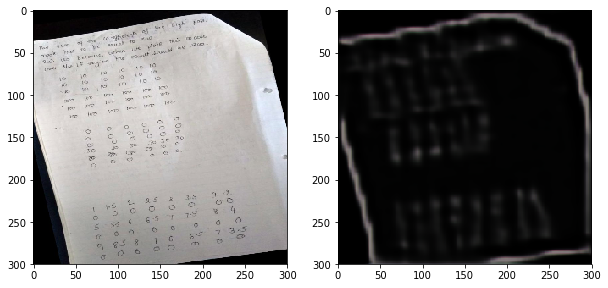

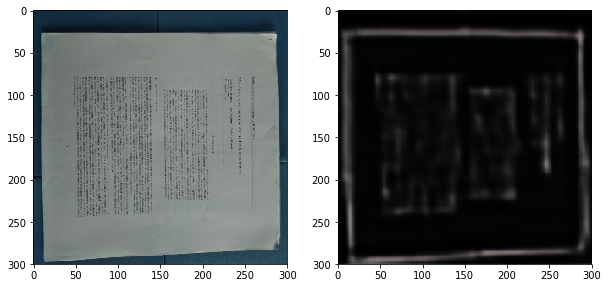

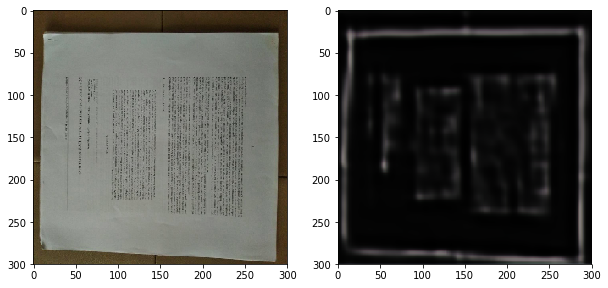

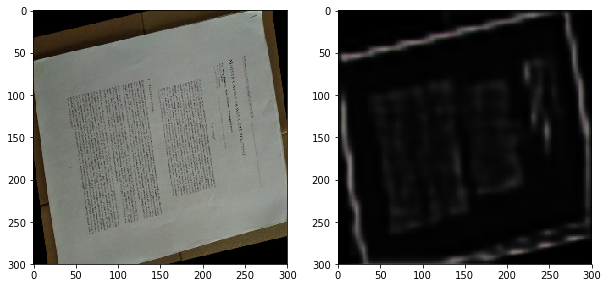

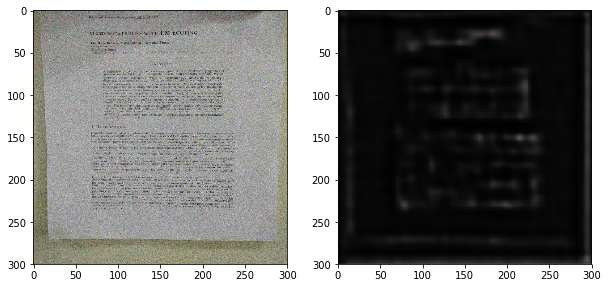

In [12]:
y_pred = autoencoder.predict(x_test_img)

for img, mask in zip(x_test_img[0:5], y_pred[0:5]):
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask)

In [11]:
i = 0
y_pred_1 = []
for name in test_names:
    width, height = cv2.imread(os.path.join(mask_path, name)).shape[1], cv2.imread(os.path.join(mask_path, name)).shape[0]
    y_pred_1.append(cv2.resize(y_pred[i], (width, height)))
    i = i + 1
y_pred_1 = np.asarray(y_pred_1)
print(y_pred_1.shape)

(18,)


In [18]:
edges = (y_pred_1[0] * 255).astype('int')
edges = edges.astype(np.uint8)
edges = cv2.cvtColor(edges, cv2.COLOR_RGB2GRAY)
print(edges.shape)

(538, 400)


In [28]:
def hough_lines(og_img,rho_resolution,theta_resolution,threshold):
    rho_theta_values = []
    height, width = og_img.shape
    hough_img = np.empty((height, width, 3))
    hough_img[:, :, 2] =  hough_img[:, :, 1] =  hough_img[:, :, 0] =  og_img/255.
    diagonal = np.sqrt(width*width + height*height)
    max_size=max(width,height)**2
    thetas = np.linspace(0,179,theta_resolution+1)
    rhos = np.linspace(-diagonal,diagonal,rho_resolution+1)
    acc = np.zeros((rho_resolution+1, theta_resolution+1))
    for x in range(0, height):
        for y in range(0, width):
            if edges[x][y] > 0:
                for t_index in range(0, len(thetas)):
                    rho = x * np.cos(thetas[t_index]) + y * np.sin(thetas[t_index])
                    for r_index in range(0, len(rhos)):
                        if rhos[r_index]>rho:
                            break
                    acc[r_index][t_index] += 1
    print(acc)
    for rho_value in range(0, len(rhos)):
        for t_value in range(0, len(thetas)):
            if acc[rho_value][t_value] >= threshold:
                rho_theta_values.append([rhos[rho_value], thetas[t_value]])
    for rho_theta in rho_theta_values:
        rho=rho_theta[0]
        theta=rho_theta[1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + max_size*(-b))
        y1 = int(y0 + max_size*(a))
        x2 = int(x0 - max_size*(-b))
        y2 = int(y0 - max_size*(a))
        cv2.line(hough_img,(x1,y1),(x2,y2),(0,0,1),4)
    plt.subplot(1,2,1)
    plt.imshow(hough_img)
    plt.subplot(1,2,2)
    plt.imshow(edges)
    plt.show()
    return rho_theta_values

In [36]:
og_img = cv2.imread(os.path.join(os.getcwd(),'photos',test_names[0]))
og_img = np.dot(og_img[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 6.40000e+03 5.85000e+02 0.00000e+00 0.00000e+00 1.82360e+04]
 [0.00000e+00 1.10327e+05 5.48400e+04 0.00000e+00 5.27970e+04 8.37860e+04]
 [3.40540e+04 2.28840e+04 8.20930e+04 1.38520e+04 8.67930e+04 3.75890e+04]
 [8.33200e+04 0.00000e+00 2.09300e+03 9.34960e+04 2.10000e+01 0.00000e+00]
 [2.22370e+04 0.00000e+00 0.00000e+00 3.22630e+04 0.00000e+00 0.00000e+00]]


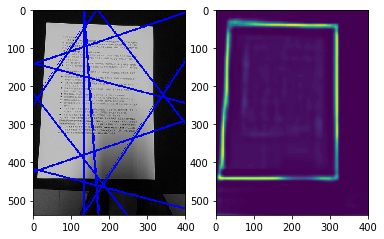

In [37]:
rho_theta_values = hough_lines(og_img,5, 5,0)